# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

Platform used for this case study: Google Colab pro

In [2]:
#Dependent packages
!pip install Pillow
!pip install scipy==1.1.0


     |████████████████████████████████| 31.2MB 87kB/s 
ERROR: pymc3 3.11.2 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [3]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import matplotlib.pyplot as plt
import imgaug as ia
from imgaug import augmenters as iaa


We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In [ ]:
# Lets the check the optimum GPU
#!nvidia-smi

Mon May 31 16:38:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    28W /  70W |  14570MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/cnn-dataset/project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/cnn-dataset/project_data/Project_data/val.csv').readlines())
train_path = '/content/drive/MyDrive/cnn-dataset/project_data/Project_data/train'
val_path = '/content/drive/MyDrive/cnn-dataset/project_data/Project_data/val'

#batch_size = #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
def generator(source_path, folder_list, batch_size, img_height=120, img_width=120):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0,29,20)).astype(int) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),img_height,img_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    img_scale = imresize(image, (img_height,image_width,3))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    #ia.seed(4)
                    #crop = iaa.Crop(percent=(0, 0.2))
                    #image_aug = crop(image=image)
                    #img_scale = imresize(image, (img_height,image_width,3))
                    batch_data[folder,idx,:,:,0] = (img_scale[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (img_scale[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (img_scale[:,:,0])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        remain_data_point = len(t)%batch_size
        if (remain_data_point !=0):
          for batch in range(remain_data_point): # we iterate over the number of batches
            batch_data = np.zeros((remain_data_point,len(img_idx),img_height,img_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remain_data_point,5)) # batch_labels is the one hot representation of the output
            for folder in range(remain_data_point): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*remain_data_point)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                  image = imread(source_path+'/'+ t[folder + (batch*remain_data_point)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                  #img_scale = imresize(image, (img_height,image_width,3))
                  #crop the images and resize them. Note that the images are of 2 different shape 
                  #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                  #ia.seed(4)
                  #crop = iaa.Crop(percent=(0, 0.2))
                  #image_aug = crop(image=image)
                  img_scale = imresize(image, (img_height,image_width,3))
                  batch_data[folder,idx,:,:,0] = (img_scale[:,:,0])/255 #normalise and feed in the image
                  batch_data[folder,idx,:,:,1] = (img_scale[:,:,0])/255 #normalise and feed in the image
                  batch_data[folder,idx,:,:,2] = (img_scale[:,:,0])/255 #normalise and feed in the image
                                    
                batch_labels[folder, int(t[folder + (batch*remain_data_point)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do



In [8]:
def module_training(model, train_path, train_doc, val_path, val_doc, num_epochs, batch_size=30 ):
  train_generator = generator(train_path, train_doc,batch_size)
  val_generator = generator(val_path, val_doc,batch_size)
  model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
  if not os.path.exists(model_name):
    os.mkdir(model_name)
        
  filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

  #LR = # write the REducelronplateau code here
  LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
  earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)

  callbacks_list = [checkpoint, LR]

  if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
  else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
  else:
    validation_steps = (num_val_sequences//batch_size) + 1

  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
  return history

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
frames = 30

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [10]:
# Data visualisation with Plots, define a function to plot.

def data_plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

**Model: Conv3D and MaxPooling3D**

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM, Bidirectional, SimpleRNN, RNN
from keras.layers.convolutional import Conv3D,Conv2D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
#write your model here

In [ ]:
# Define base model
image_height=160
image_width=160

model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(frames,image_height,image_width,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(5,activation='softmax'))
        

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 80, 80, 32)    1

In [ ]:
#Let's check the number of parameter
print("Number of parameters:", model.count_params())


Number of parameters: 1728197


In [ ]:
#num_epochs=15
#history = module_training(model, train_path, train_doc, val_path, val_doc, num_epochs )


Source path =  /content/drive/MyDrive/cnn-dataset/project_data/Project_data/train ; batch size = 30


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/15
23/23 [==============================] - 945s 41s/step - loss: 0.6870 - categorical_accuracy: 0.0756 - val_loss: 0.5486 - val_categorical_accuracy: 0.0500

Epoch 00001: saving model to model_init_2021-05-3113_20_00.931938/model-00001-0.54056-0.09710-0.54858-0.05000.h5
Epoch 2/15
23/23 [==============================] - 670s 30s/step - loss: 0.3337 - categorical_accuracy: 0.0807 - val_loss: 0.6091 - val_categorical_accuracy: 0.0583

Epoch 00002: saving model to model_init_2021-05-3113_20_00.931938/model-00002-0.32132-0.10290-0.60914-0.05833.h5
Epoch 3/15
23/23 [==============================] - 543s 25s/step - loss: 0.3086 - categorical_accuracy: 0.1893 - val_loss: 0.7560 - val_categorical_accuracy: 0.0417

Epoch 00003: saving model to model_init_2021-05-3113_20_00.931938/model-00003-0.32526-0.21449-0.75599-0.04167.h5
Epoch 4/15
23/23 [==============================] - 473s 21s/step - loss: 0.3120 - categorical_accuracy: 0.2787 - val_loss: 0.8749 - val_categorical_accuracy: 0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

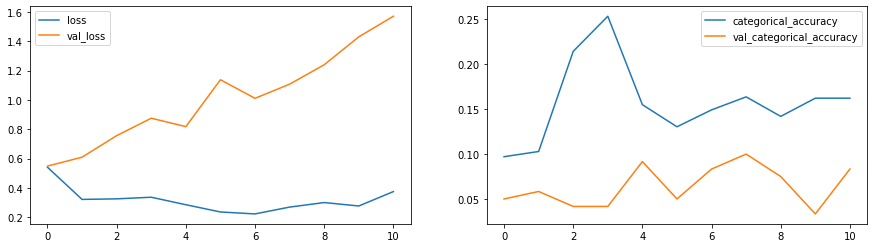

In [ ]:
#data_plot(history)


**Model- CNN-LSTM**

In [ ]:
# CNN-LSTM Model
image_height=160
image_width=160
cnn_lstm = Sequential()
cnn_lstm.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(None,image_height,image_width,3)))
cnn_lstm.add(TimeDistributed(BatchNormalization()))
cnn_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))
        
cnn_lstm.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
cnn_lstm.add(TimeDistributed(BatchNormalization()))
cnn_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))
        
cnn_lstm.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
cnn_lstm.add(TimeDistributed(BatchNormalization()))
cnn_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))
        
cnn_lstm.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
cnn_lstm.add(TimeDistributed(BatchNormalization()))
cnn_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

cnn_lstm.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
cnn_lstm.add(TimeDistributed(BatchNormalization()))
cnn_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

cnn_lstm.add(TimeDistributed(Flatten()))
cnn_lstm.add(LSTM(128))
cnn_lstm.add(Dropout(0.25))
        
cnn_lstm.add(Dense(128,activation='relu'))
cnn_lstm.add(Dropout(0.25))
        
cnn_lstm.add(Dense(5, activation='softmax'))


In [ ]:
cnn_lstm.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

cnn_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 160, 160, 16 448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 160, 160, 16 64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 80, 80, 16)  0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 80, 80, 32)  4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 80, 80, 32)  128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 40, 40, 32)  0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 40, 40, 64)  1

In [ ]:
print("Total Params:", cnn_lstm.count_params())


Total Params: 3754597


In [ ]:
num_epochs=20
batch_size=20
#module_training(model, train_path, train_doc, val_path, val_doc, num_epochs, frames, image_augment=0 ):
#module_training(model, train_path, train_doc, val_path, val_doc, num_epochs, batch_size=20 )

history = module_training(cnn_lstm, train_path, train_doc, val_path, val_doc,num_epochs,batch_size )


Source path =  /content/drive/MyDrive/cnn-dataset/project_data/Project_data/train ; batch size = 20


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  


Epoch 1/20
34/34 [==============================] - 1234s 36s/step - loss: 1.5999 - categorical_accuracy: 0.3015 - val_loss: 1.6551 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2021-05-3119_23_04.381034/model-00001-1.49935-0.34265-1.65511-0.16000.h5
Epoch 2/20
34/34 [==============================] - 24s 733ms/step - loss: 1.2828 - categorical_accuracy: 0.4504 - val_loss: 2.1664 - val_categorical_accuracy: 0.1300

Epoch 00002: saving model to model_init_2021-05-3119_23_04.381034/model-00002-1.27146-0.45294-2.16644-0.13000.h5
Epoch 3/20
34/34 [==============================] - 19s 581ms/step - loss: 1.1507 - categorical_accuracy: 0.5210 - val_loss: 2.2451 - val_categorical_accuracy: 0.1600

Epoch 00003: saving model to model_init_2021-05-3119_23_04.381034/model-00003-1.14072-0.51618-2.24511-0.16000.h5
Epoch 4/20
34/34 [==============================] - 19s 587ms/step - loss: 1.0303 - categorical_accuracy: 0.5675 - val_loss: 2.2874 - val_categorical_accurac

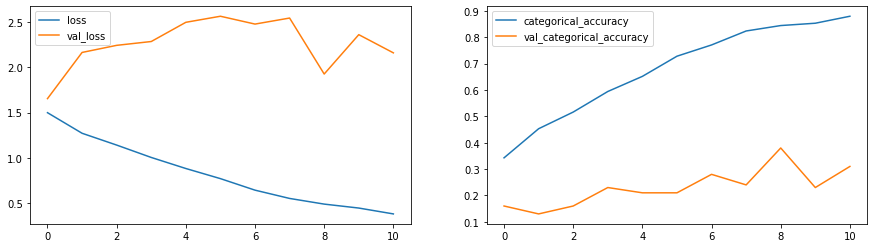

In [ ]:
data_plot(history)

In [ ]:
# CNN-LSTM Model
image_height=120
image_width=120
cnn_lstm = Sequential()
cnn_lstm.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(None,image_height,image_width,3)))
cnn_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))
        
cnn_lstm.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
cnn_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))
        
cnn_lstm.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
cnn_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))
        
cnn_lstm.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
cnn_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

cnn_lstm.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
cnn_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))


cnn_lstm.add(TimeDistributed(Flatten()))
cnn_lstm.add(LSTM(128))
cnn_lstm.add(Dropout(0.25))
        
cnn_lstm.add(Dense(128,activation='relu'))
cnn_lstm.add(Dropout(0.25))
        
cnn_lstm.add(Dense(5, activation='softmax'))

In [ ]:

optimiser = optimizers.Adam()
cnn_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

cnn_lstm.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_98 (TimeDis (None, None, 120, 120, 16 448       
_________________________________________________________________
time_distributed_99 (TimeDis (None, None, 60, 60, 16)  0         
_________________________________________________________________
time_distributed_100 (TimeDi (None, None, 60, 60, 32)  4640      
_________________________________________________________________
time_distributed_101 (TimeDi (None, None, 30, 30, 32)  0         
_________________________________________________________________
time_distributed_102 (TimeDi (None, None, 30, 30, 64)  18496     
_________________________________________________________________
time_distributed_103 (TimeDi (None, None, 15, 15, 64)  0         
_________________________________________________________________
time_distributed_104 (TimeDi (None, None, 15, 15, 128)

In [ ]:
print("Total Params:", cnn_lstm.count_params())


Total Params: 1655461


In [ ]:
num_epochs=20
batch_size=20

history = module_training(cnn_lstm, train_path, train_doc, val_path, val_doc,num_epochs,batch_size )


Source path =  /content/drive/MyDrive/cnn-dataset/project_data/Project_data/train ; batch size = 20


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  


Epoch 1/20
33/34 [============================>.] - ETA: 3s - loss: 1.6162 - categorical_accuracy: 0.2270

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 152s 4s/step - loss: 1.6161 - categorical_accuracy: 0.2261 - val_loss: 1.6047 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2021-06-0105_15_52.384608/model-00001-1.61462-0.21116-1.60473-0.23000.h5
Epoch 2/20
34/34 [==============================] - 124s 4s/step - loss: 1.5990 - categorical_accuracy: 0.1992 - val_loss: 1.6016 - val_categorical_accuracy: 0.3100

Epoch 00002: saving model to model_init_2021-06-0105_15_52.384608/model-00002-1.59130-0.21207-1.60162-0.31000.h5
Epoch 3/20
34/34 [==============================] - 121s 4s/step - loss: 1.5873 - categorical_accuracy: 0.2512 - val_loss: 1.3176 - val_categorical_accuracy: 0.4600

Epoch 00003: saving model to model_init_2021-06-0105_15_52.384608/model-00003-1.54595-0.28299-1.31761-0.46000.h5
Epoch 4/20
34/34 [==============================] - 120s 4s/step - loss: 1.4975 - categorical_accuracy: 0.3324 - val_loss: 1.2609 - val_categorical_accuracy: 0.5400

Epoch 00

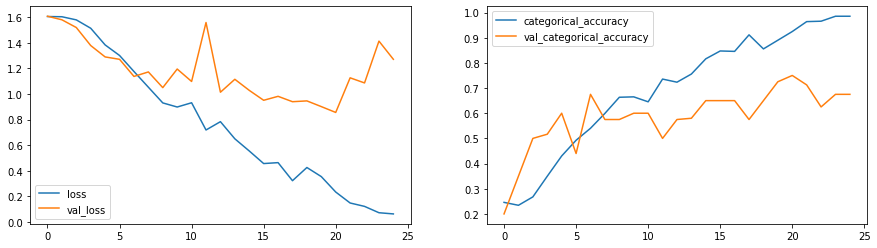

In [ ]:
data_plot(history_lstm)

In [12]:
# CNN-GRU Model
image_height=120
image_width=120
cnn_gru = Sequential()
cnn_gru.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(None,image_height,image_width,3)))
cnn_gru.add(TimeDistributed(MaxPooling2D((2, 2))))
        
cnn_gru.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
cnn_gru.add(TimeDistributed(MaxPooling2D((2, 2))))
        
cnn_gru.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
cnn_gru.add(TimeDistributed(MaxPooling2D((2, 2))))
        
cnn_gru.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
cnn_gru.add(TimeDistributed(MaxPooling2D((2, 2))))


cnn_gru.add(TimeDistributed(Flatten()))
cnn_gru.add(GRU(128))
cnn_gru.add(Dropout(0.25))
        
cnn_gru.add(Dense(128,activation='relu'))
cnn_gru.add(Dropout(0.25))
        
cnn_gru.add(Dense(5, activation='softmax'))

In [13]:

optimiser = optimizers.Adam()
cnn_gru.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

cnn_gru.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 120, 120, 16 448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 60, 60, 16)  0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 60, 60, 32)  4640      
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 30, 30, 32)  0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 30, 30, 64)  18496     
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 15, 15, 64)  0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 15, 15, 128) 7

In [14]:
num_epochs=20
batch_size=20

history = module_training(cnn_gru, train_path, train_doc, val_path, val_doc,num_epochs,batch_size )

Source path =  /content/drive/MyDrive/cnn-dataset/project_data/Project_data/train ; batch size = 20


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  


Epoch 1/20
33/34 [============================>.] - ETA: 2:00 - loss: 1.6410 - categorical_accuracy: 0.2029

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 4571s 137s/step - loss: 1.6398 - categorical_accuracy: 0.2044 - val_loss: 1.5749 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model_init_2021-06-0112_21_59.842966/model-00001-1.62030-0.22926-1.57488-0.24000.h5
Epoch 2/20
34/34 [==============================] - 95s 3s/step - loss: 1.5678 - categorical_accuracy: 0.3038 - val_loss: 1.3963 - val_categorical_accuracy: 0.5700

Epoch 00002: saving model to model_init_2021-06-0112_21_59.842966/model-00002-1.51781-0.34056-1.39626-0.57000.h5
Epoch 3/20
34/34 [==============================] - 72s 2s/step - loss: 1.3474 - categorical_accuracy: 0.4172 - val_loss: 1.3157 - val_categorical_accuracy: 0.4700

Epoch 00003: saving model to model_init_2021-06-0112_21_59.842966/model-00003-1.25827-0.47854-1.31570-0.47000.h5
Epoch 4/20
34/34 [==============================] - 65s 2s/step - loss: 1.1607 - categorical_accuracy: 0.5476 - val_loss: 1.1275 - val_categorical_accuracy: 0.5200

Epoch 00

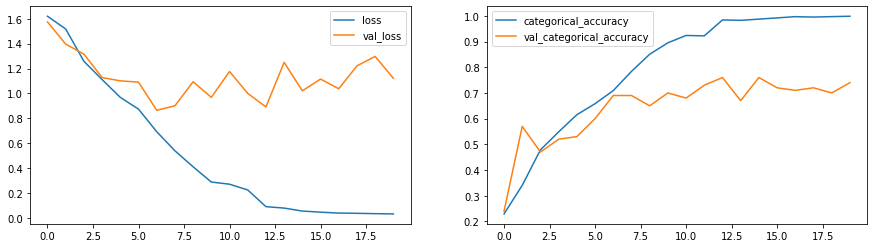

In [16]:
data_plot(history)

We have experimented multiple models out of which the CNN+GRU has been performed the best

- (Training Accuracy : 95%, Validation Accuracy : 76%)

- Number of Parameters : 2,572,965, we could increase the model val accuracy by adding more dense layers, however due the resources limitations we have to stopped with tless params


The best weights of CNN-GRU: Epoch 00013: saving model to model_init_2021-06-0112_21_59.842966/model-00013-0.08934-0.98410-0.89130-0.76000.h5.